<a href="https://colab.research.google.com/github/DoryAbelman/CARTE-ML-Program/blob/main/lab_3_2_PyTorch_Dory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building a Neural Network with PyTorch and PyTorch Lightning

In this lab, we will dive into building our own neural network using PyTorch and PyTorch Lightning. We'll work with our HCC data and build a simple neural network to predict whether a sample has cancer or not.

In [1]:
!pip install -U -q torch torchvision pytorch-lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 801.9/801.9 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 3.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.2.1+cu121 requires torch==2.2.1, but you have torch 2.2.2 which is incompatible.
torchtext 0.17.1 requires torch==2.2.1, but you have torch 2.2.2 which is incompatible.


In [30]:
import pandas as pd
hcc = pd.read_csv('https://github.com/alexwolson/carte_workshop_2024/raw/main/data/HCC_all_ML_classification_test_annotated_frags_all_features_combined_4_tumors.csv.gz', compression='gzip')
hcc = hcc.sample(50000)

In [31]:
categorical_columns = ['upstream_motif','downstream_motif','Corrected_Call']
numerical_columns = ['frag','VAF','plasma_VAF','Corrected_Copy_Number']
y_column = 'alt_match'

X = hcc[categorical_columns + numerical_columns]
y = hcc[y_column]

In [32]:
X = pd.get_dummies(X, columns=categorical_columns)

In [33]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

## Building a Neural Network with PyTorch

PyTorch is a popular deep learning framework that allows you to build neural networks. PyTorch is a bit more low-level than TensorFlow, which handles some of the details for you. However, PyTorch is more flexible and allows you to build custom neural networks with ease.

In order to keep things simple, we will also take advantage of a companion library called PyTorch Lightning. Lightning takes care of much of the code that normally needs to be written by hand, allowing you to focus on building your neural network. Despite this, we will still need to write a fair amount of code to build our neural network.

Let's start by defining a simple, fully connected neural network using PyTorch.

In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as L

class NN(L.LightningModule):

    def __init__(self):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 32) # output 32 width
        self.fc2 = nn.Linear(32, 4) # from that take 32 output 4
        self.fc3 = nn.Linear(4, 1) # from that take 4 output 1
        # Add additional layers following the same format. Bring us down to a single output

    def forward(self, x):
        # Define the forward pass of the network
        # Alternate between linear layers and activation functions
        # Relu can be called using F.relu
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.sigmoid(self.fc3(x))

        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.binary_cross_entropy(y_hat, y.view(-1, 1))
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

## Training the Model

Now that we have defined our neural network, we can train it using PyTorch Lightning. We will create a PyTorch Dataset and DataLoader to feed our data into the model, and then use a Trainer to train the model. The Dataset and DataLoader classes have us define exactly how our data should be retrieved and fed into the model, while the Trainer class handles the training loop for us.

In [35]:
class HCCDataset(torch.utils.data.Dataset):

    def __init__(self, X, y):
        self.X = torch.tensor(X.values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # This is the important function that defines how data is retrieved from the dataset
        return self.X[idx], self.y[idx]

In [36]:
train_dataset = HCCDataset(X_train.astype(float), y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = HCCDataset(X_val.astype(float), y_val)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

model = NN()
trainer = L.Trainer(max_epochs=10, log_every_n_steps=1)
trainer.fit(model, train_loader, val_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:72: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name | Type   | Params
--------------------------------
0 | fc1  | Linear | 16.8 K
1 | fc2  | Linear | 132   
2 | fc3  | Linear | 5     
--------------------------------
17.0 K    Trainable params
0         Non-trainable params
17.0 K    Total params
0.068     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


## Evaluating the Model

Now that we have trained our model, we can evaluate it on the test set to see how well it performs.

In [37]:
from sklearn.metrics import accuracy_score

test_dataset = HCCDataset(X_test.astype(float), y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

Just like how we defined a training loop for our model, we have to define an evaluation loop to evaluate the model on the test set. There are a few key elements to this:

1. We need to set the model to evaluation mode using `model.eval()`. This tells PyTorch that we are evaluating the model and not training it.
2. We need to use the `torch.no_grad()` context manager to tell PyTorch that we do not need to keep track of gradients during evaluation. This can save memory and speed up computation.
3. We need to loop over the test set and compute predictions using the model. We can then use these predictions to compute the accuracy of the model.

In [38]:
# Switch the model to evaluation mode
model.eval()

# Use torch.no_grad() to disable gradient tracking
with torch.no_grad():
    y_true = []
    y_pred = []

    # Loop over the test set
    for x, y in test_loader:
        y_hat = model(x) # Compute predictions
        y_hat = (y_hat > 0.5).float() # Convert to binary predictions

        # Append the true and predicted labels to the lists
        y_true.extend(y.numpy())
        y_pred.extend(y_hat.numpy().flatten())

Now `y_pred` and `y_true` contain the predicted and true labels for the test set. We can use these to compute the accuracy of the model.

In [39]:
# Compute the accuracy of the model

# ===== YOUR CODE HERE =====

accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy: {accuracy:.3f}')

# ==========================

Accuracy: 0.970


# Extending our model further

Now that we have a simple neural network that can predict whether a sample has cancer or not, we can extend it further to improve its performance. Here are a few ideas for how you can extend the model:

1. Add more layers to the neural network. You can experiment with different widths, depths and activations to see how they affect the performance of the model.
2. Experiment with different optimization algorithms. You can try using different optimizers such as SGD, RMSprop, or Adam, and experiment with different learning rates.
3. There are many settings that can be configured with the Lightning Trainer. Take a look at the [callbacks](https://pytorch-lightning.readthedocs.io/en/latest/extensions/callbacks.html) (particularly EarlyStopping and ModelCheckpoint) and [logging](https://pytorch-lightning.readthedocs.io/en/latest/extensions/logging.html) options to see how you can monitor and improve your model during training.

In [40]:
class NN(L.LightningModule):

    def __init__(self):
        super(NN, self).__init__()
        # Add more layers to the neural network
        self.fc1 = nn.Linear(X_train.shape[1], 64) # output 64 width
        self.fc2 = nn.Linear(64, 32) # from that take 64 output 32
        self.fc3 = nn.Linear(32, 16) # from that take 32 output 16
        self.fc4 = nn.Linear(16, 1) # from that take 16 output 1

    def forward(self, x):
        # Define the forward pass of the network
        # Alternate between linear layers and activation functions
        # Relu can be called using F.relu
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.sigmoid(self.fc4(x))

        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.binary_cross_entropy(y_hat, y.view(-1, 1))
        return loss

    def configure_optimizers(self):
        # Experiment with different optimization algorithms
        # Using Adam optimizer with a learning rate of 0.001
        return torch.optim.Adam(self.parameters(), lr=0.001)


In [41]:
## Now train new model

train_dataset = HCCDataset(X_train.astype(float), y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = HCCDataset(X_val.astype(float), y_val)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

model = NN()
trainer = L.Trainer(max_epochs=10, log_every_n_steps=1)
trainer.fit(model, train_loader, val_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:72: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name | Type   | Params
--------------------------------
0 | fc1  | Linear | 33.7 K
1 | fc2  | Linear | 2.1 K 
2 | fc3  | Linear | 528   
3 | fc4  | Linear | 17    
--------------------------------
36.3 K    Trainable params
0         Non-trainable params
36.3 K    Total params
0.145     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [42]:
# Now evaluate the model


test_dataset = HCCDataset(X_test.astype(float), y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy: {accuracy:.3f}')


Accuracy: 0.970


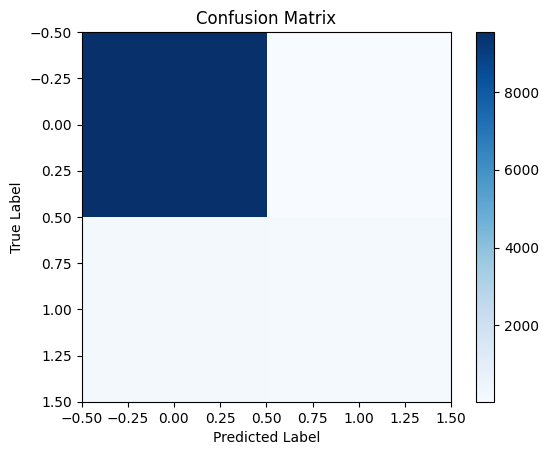

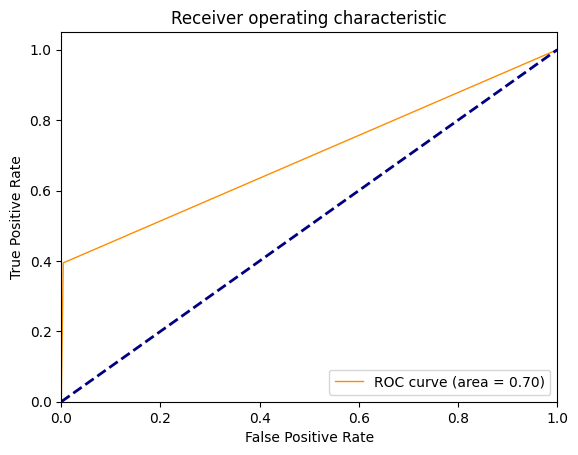

In [45]:
# prompt: Make me a contigency table and roc curves with this accuracy = accuracy_score(y_true, y_pred)
# print(f'Accuracy: {accuracy:.3f}')

from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.imshow(cm, cmap='Blues')
plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()


# Tracking Experiments

Often, we want to be able to keep track of the experiments we run, including the hyperparameters, metrics, and other information. One way to do this is to use a tool like [Weights & Biases](https://wandb.ai/site) (wandb) to log and visualize our experiments.

In order to use wandb, you will need to sign up for an account and install the wandb library. You can do this by running `!pip install wandb` in a code cell.

In [46]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.1/267.1 kB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.2 MB/s eta 0:00:00


In [47]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [48]:
# Initialize a new wandb run

run = wandb.init(project='hcc', config={
    'learning_rate': 0.001,
    'batch_size': 32,
    'epochs': 10
})

wandb: Currently logged in as: dory-abelman (cfwgs). Use `wandb login --relogin` to force relogin


Now that we've initialized a wandb run, we can log information about our model and training process. Pytorch Lightning has built-in support for wandb, so we can easily log metrics, hyperparameters, and other information during training.

In [49]:
from pytorch_lightning.loggers import WandbLogger

wandb_logger = WandbLogger(log_model=True) # Save the model as an artifact

model = NN()

trainer = L.Trainer(max_epochs=10, logger=wandb_logger)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Once we have trained our model, we can log the final metrics and any other information we want to keep track of. You'll then be able to view this information in the wandb dashboard: [https://wandb.ai/home](https://wandb.ai/home)